In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.differentiate import jacobian
from scipy.optimize import fsolve

In [2]:
def nrbase(f, x0, delta):
    dfdx = (f(x0+delta)-f(x0-delta))/delta/2
    x1 = x0 - f(x0)/dfdx
    return x1

In [3]:
def g(x):
    return x**2 - 1

In [4]:
x0 = -10
delta = 0.1
x1 = nrbase(g,x0,delta)

In [5]:
while abs(x1-x0) > 1e-5:
    x0 = x1
    x1 = nrbase(g,x0,delta)
x1

-1.0000000000139897

In [6]:
def nrmethod(f,x0,delta,eps):
    dfdx = (f(x0+delta)-f(x0-delta))/delta/2
    x1 = x0 - f(x0)/dfdx
    while abs(x1-x0) > eps:
        x0 = x1
        dfdx = (f(x0+delta)-f(x0-delta))/delta/2
        x1 = x0 - f(x0)/dfdx
    return x1

In [7]:
def h(x):
    return 2*x**3 -5* x**2 + 3*x + 5

In [8]:
nrmethod(h,10,1e-3,1e-5)

-0.6815201528763917

In [10]:
def rkheun(f,y1,ini,fin,h):
    interval=np.linspace(ini,fin,int(1/h))
    for i in range(len(interval)):
        k1=f(interval[i],y1)
        k2=f(interval[i]+h,y1+h*k1)
        y1=y1+(k1+k2)*h/2
    return y1

In [11]:
def oderhs(x,y):
    return y

In [12]:
rkheun(oderhs,1,0,1,1e-5)

2.718254645731375

In [13]:
sol = solve_ivp(oderhs,[0,1],[1],'RK45')
sol.y[0][-1] - rkheun(oderhs,1,0,1,1e-5)

np.float64(7.235377031555856e-05)

In [14]:
def nrmethod2D(f,x0,eps):
    jac = jacobian(f,x0).df
    x1 = x0 - np.linalg.inv(jac)@f(x0)
    while True:
        x0 = x1
        jac = jacobian(f,x0).df
        x1 = x0 - np.linalg.inv(jac)@f(x0)
        if (abs(x1-x0) < eps).all():
            break
    return x1

In [15]:
def func(x):
    x1, x2 = x
    return [x1**2-x2,x1-x2**2]

In [16]:
nrmethod2D(func,[0.3,1.2],1e-4)

array([1., 1.])

In [17]:
fsolve(func,[0.3,1.2])-nrmethod2D(func,[0.3,1.2],1e-4)

array([-2.96511704e-11, -2.70858891e-11])

In [18]:
def rkheun2D(f,y0,ydot0,ini,fin,n):

    h = (fin-ini)/n
    t=np.linspace(ini,fin,n)

    y=np.empty(n)
    ydot=np.empty(n)
    
    y[0], ydot[0] = y0, ydot0
    for i in range(n-1):
        k1=f(t[i],y[i],ydot[i])
        k2=f(t[i+1],y[i]+h*ydot[i],ydot[i]+h*k1)
        y[i+1]=y[i] + h*ydot[i] + 0.5 * h**2 * k1
        ydot[i+1]=ydot[i] + 0.5*h*(k1+k2)

    return t, y, ydot

# np.empty(0)와 np.append를 넣어서 돌렸더니 너무 느려서 claude에게 물어보았고.
# 해당 코드는 O(n^2) 복잡도를 지니고 미리 array allocation을 하면 O(n)으로 줄어든다고 답함.

In [19]:
def yddot(t,y,ydot):
    return - y

Matplotlib is building the font cache; this may take a moment.


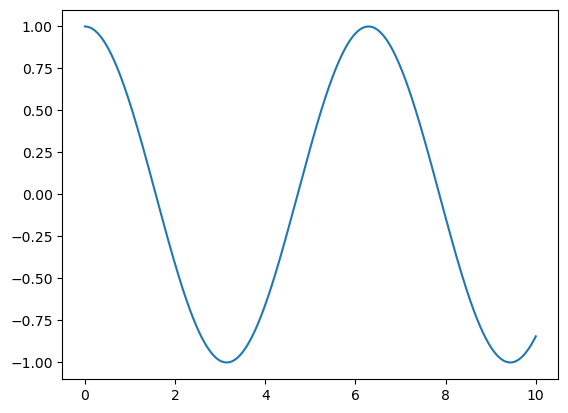

In [20]:
t, y, ydot = rkheun2D(yddot,1.,0.,0.,10.,1000)
import matplotlib.pyplot as plt
plt.plot(t,y)

In [58]:
def rkheunPoisson(phiddot,hdot,phi_ini,h_ini,t_ini,t_fin,point,Rs):

    step = (t_fin-t_ini)/point
    t=np.linspace(t_ini,t_fin,point)

    phi=np.empty(point)
    phidot=np.empty(point)

    h=np.empty(point)
    
    phi[0], phidot[0] = phi_ini
    h[0] = h_ini

    for i in range(point-1):
        k1phi=phiddot(t[i],phi[i],phidot[i],h[i],Rs)
        k1h=hdot(t[i],phi[i],phidot[i],h[i],Rs)
        k2phi=phiddot(t[i+1],phi[i]+step*phidot[i],phidot[i]+step*k1phi,h[i]+step*k1h,Rs)
        k2h=hdot(t[i+1],phi[i]+step*phidot[i],phidot[i]+step*k1phi,h[i]+step*k1h,Rs)
        print(np.shape(k1phi),np.shape(phi[0]))

        phi[i+1]=phi[i] + step*phidot[i] + 0.5 * step**2 * k1phi
        phidot[i+1]=phidot[i] + 0.5*step*(k1phi+k2phi)
        h[i+1]=h[i] + 0.5*step*(k1h+k2h)
       

    return t, phi, phidot, h

In [50]:
K = 1.0*1e2
n = 0.8
rhoc = 1.28*1e-3

def hdot(rhat,phi,phidot,h,Rs):
    return - phidot

def phiddot(rhat,phi,phidot,h,Rs):
    return -(2./rhat)*phidot + 4.*np.pi* Rs**2 * (h/(K*(n+1)))**n

In [51]:
phi_ini=[0.0,0.0]
h_ini=K*(1+n)*rhoc**(1./n)

rhat_ini = 1.0e-5
rhat_fin = 0.5
point = 500

rhat, phi, phidot, h = rkheunPoisson(phiddot,hdot,phi_ini,h_ini,rhat_ini,rhat_fin,point,Rs = 1.0*1e-5)

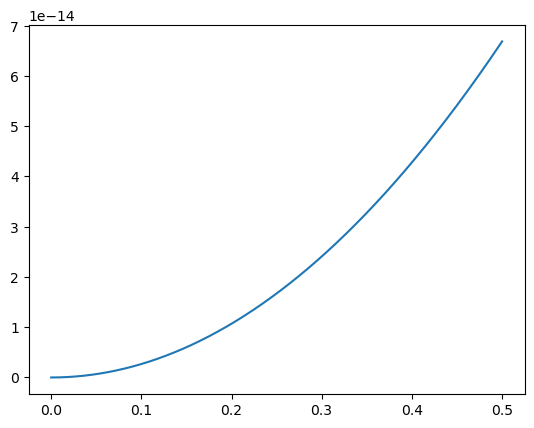

In [52]:
plt.plot(rhat,phi)

In [59]:
def phidot_1(Rs,phidot_s):
    _, _, phidot, _ = rkheunPoisson(phiddot,hdot,[0.0,0.0],K*(1+n)*rhoc**(1./n),1e-5,0.5,500,Rs)
    return phidot(-1)

def phidot_2(Rs,phidot_s):
    _, _, phidot, _ = rkheunPoisson(phiddot,hdot,[-Rs*phidot_s,phidot_s],0,1.0,0.5,500,Rs)
    return phidot(0)

def func(x):
    Rs,phidot_s = x
    return np.array(phidot_1(Rs,phidot_s))- np.array(phidot_2(Rs,phidot_s))

def shooting(Rs_start,phidot_start):
    Rs,phidot = nrmethod2D(func, [Rs_start,phidot_start],1e-5)
    return Rs,phidot

In [60]:
shooting(0,0)

(2,) ()


ValueError: setting an array element with a sequence.